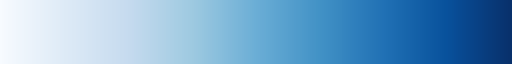

In [1]:
import pandas as pd
import seaborn as sns
from glob import glob
import json
import random

from IPython.display import Audio, display
import sys
import os

import torch

sys.path.append(os.path.abspath('../../'))
sns.color_palette("Blues", as_cmap=True)

In [2]:
log_dir_2 = os.path.join("..", "..", "logs","2_classes_full_dataset_sweep_ViT")
if not os.path.exists(log_dir_2):
    print(f"Folder '{log_dir_2}' does not exist.")
else:
    run_dirs_2 = sorted(glob(os.path.join(log_dir_2, 'run_*')),
                      key=lambda x: int(os.path.basename(x).split('_')[1]))
    print(f"Found {len(run_dirs_2)} runs for unknown.")

Found 16 runs for unknown.


In [3]:
log_dir_11 = os.path.join("..", "..", "logs","11_classes_full_dataset_sweep_ViT")
if not os.path.exists(log_dir_11):
    print(f"Folder '{log_dir_11}' does not exist.")
else:
    run_dirs_11 = sorted(glob(os.path.join(log_dir_11, 'run_*')),
                      key=lambda x: int(os.path.basename(x).split('_')[1]))
    print(f"Found {len(run_dirs_11)} runs for known.")

Found 17 runs for known.


In [4]:
def get_results(run_dirs):
    max_accuracies = []
    lr_values = []
    weight_decay_values = []
    scheduler_values = []

    for run_dir in run_dirs[1:]:
        val_csv = os.path.join(run_dir, 'validation_metrics.csv')
        config_json = os.path.join(run_dir, 'config.json')
        if os.path.exists(val_csv):
            df = pd.read_csv(val_csv)
            max_acc = df['acc/val'].max()
            run_num = os.path.basename(run_dir).split('_')[1]
            max_accuracies.append((int(run_num), max_acc))

            if os.path.exists(config_json):
                with open(config_json, 'r') as f:
                    config = json.load(f)
                    lr_values.append(config['training']['lr'])
                    weight_decay_values.append(config['training']['weight_decay'])
                    scheduler_values.append(config['training']['scheduler'])

    results = pd.DataFrame(max_accuracies, columns=['Run', 'Max Validation Accuracy'])
    results['Learning Rate'] = lr_values
    results['Weight Decay'] = weight_decay_values
    results['Scheduler'] = scheduler_values
    results['Scheduler'] = results['Scheduler'].apply(lambda x: 'None' if x == None else x)
    return results

In [5]:
columns_order = ['Run', 'Learning Rate', 'Weight Decay', 'Scheduler', 'Max Validation Accuracy']
results_2 = get_results(run_dirs_2)
results_2 = results_2[columns_order]

print(results_2)

    Run  Learning Rate  Weight Decay Scheduler  Max Validation Accuracy
0     2         0.0003        0.0010    cosine                 0.931450
1     3         0.0003        0.0001      None                 0.928214
2     4         0.0003        0.0010      None                 0.929391
3     5         0.0010        0.0001    cosine                 0.874669
4     6         0.0010        0.0010    cosine                 0.936011
5     7         0.0010        0.0001      None                 0.928950
6     8         0.0010        0.0010      None                 0.881877
7     9         0.0030        0.0001    cosine                 0.646219
8    10         0.0030        0.0010    cosine                 0.630627
9    11         0.0030        0.0001      None                 0.681965
10   12         0.0030        0.0010      None                 0.625919
11   13         0.0100        0.0001    cosine                 0.620918
12   14         0.0100        0.0010    cosine                 0

In [6]:
columns_order = ['Run', 'Learning Rate', 'Weight Decay', 'Scheduler', 'Max Validation Accuracy']
results_11 = get_results(run_dirs_11)
results_11 = results_11[columns_order]

print(results_11)

    Run  Learning Rate  Weight Decay Scheduler  Max Validation Accuracy
0     2         0.0003        0.0001    cosine                 0.858750
1     3         0.0003        0.0010    cosine                 0.854094
2     4         0.0003        0.0001      None                 0.856034
3     5         0.0003        0.0010      None                 0.864183
4     6         0.0010        0.0001    cosine                 0.891347
5     7         0.0010        0.0010    cosine                 0.897555
6     8         0.0010        0.0001      None                 0.890182
7     9         0.0010        0.0010      None                 0.897943
8    10         0.0030        0.0001    cosine                 0.734963
9    11         0.0030        0.0010    cosine                 0.675592
10   12         0.0030        0.0001      None                 0.669771
11   13         0.0030        0.0010      None                 0.693442
12   14         0.0100        0.0001    cosine                 0

In [7]:
best_run = results_2.loc[results_2['Max Validation Accuracy'].idxmax()]

print("Best Performing Run:")
print(best_run)

Best Performing Run:
Run                               6
Learning Rate                 0.001
Weight Decay                  0.001
Scheduler                    cosine
Max Validation Accuracy    0.936011
Name: 4, dtype: object


In [8]:
best_run = results_11.loc[results_11['Max Validation Accuracy'].idxmax()]

print("Best Performing Run:")
print(best_run)

Best Performing Run:
Run                               9
Learning Rate                 0.001
Weight Decay                  0.001
Scheduler                      None
Max Validation Accuracy    0.897943
Name: 7, dtype: object


In [9]:
UNKNOWN_PROJECT = '2_classes_full_dataset_sweep_ViT'
KNOWN_PROJECT = '11_classes_full_dataset_sweep_ViT'

UKNOWN_RUN = 4
KNOWN_RUN = 9

LOGS_DIR = '../../logs'

CONFIG_UNKNOWN = f'{LOGS_DIR}/{UNKNOWN_PROJECT}/run_{UKNOWN_RUN}/config.json'
MODEL_PATH_UNKNOWN = f"{LOGS_DIR}/{UNKNOWN_PROJECT}/run_{UKNOWN_RUN}/best.pth"
CONFIG_KNOWN = f'{LOGS_DIR}/{KNOWN_PROJECT}/run_{KNOWN_RUN}/config.json'
MODEL_PATH_KNOWN = f"{LOGS_DIR}/{KNOWN_PROJECT}/run_{KNOWN_RUN}/best.pth"

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(os.path.abspath('../'))

with open(CONFIG_KNOWN) as f:
    cfg = json.load(f)

class Config:
    def __init__(self, dictionary):
        for k, v in dictionary.items():
            if isinstance(v, dict):
                setattr(self, k, Config(v))
            else:
                setattr(self, k, v)

cfg = Config(cfg)
cfg.data.root = os.path.join('..', '..', 'data')

cfg.data.unknown_commands_included = True
cfg.data.silence_included = True


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\jdudz\AppData\Roaming\uv\python\cpython-3.10.16-windows-x86_64-none\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\jdudz\AppData\Roaming\uv\python\cpython-3.10.16-windows-x86_64-none\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\jdudz\PycharmProjects\DeepLearningSpeechRecognition\.venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\jdudz\Pycharm

In [11]:
from dataset.dataset import SpeechCommandsDataset

test_dataset = SpeechCommandsDataset(
    root_dir=cfg.data.root,
    cfg=cfg,
    mode='testing'
)
print(test_dataset.target_commands)

num_classes:  12
Class balance in testing data:
  down: 253
  go: 251
  left: 267
  no: 252
  off: 262
  on: 246
  right: 259
  stop: 249
  up: 272
  yes: 256
  _silence_: 39
  _unknown_: 4268
  unknown percentage: 62.09%
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', '_silence_']


In [12]:
import torch
from modeling.model import build_model

model_known = build_model(cfg, 11)

state_dict = torch.load(MODEL_PATH_KNOWN, map_location=torch.device('cpu'))
model_known.load_state_dict(state_dict)

model_unknown = build_model(cfg, 2)

state_dict = torch.load(MODEL_PATH_UNKNOWN, map_location=torch.device('cpu'))
model_unknown.load_state_dict(state_dict)

class EnsembleStrategy(torch.nn.Module):
    def __init__(self, model_unknown, model_known):
        super(EnsembleStrategy, self).__init__()
        self.model_unknown = model_unknown
        self.model_known = model_known

    def forward(self, x):
        output_unknown = self.model_unknown(x)
        output_known = self.model_known(x)
        if output_unknown[0][1] > 0.5:
            return torch.cat((output_known * 0., torch.tensor([[output_unknown[0][1]]], device=output_unknown.device)), dim=1)
        return torch.cat((output_known, torch.tensor([[0.]], device=output_unknown.device)), dim=1)
model = EnsembleStrategy(model_unknown, model_known)
model.eval()

print("Model loaded successfully!")

C:\Users\jdudz\PycharmProjects\DeepLearningSpeechRecognition\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded successfully!


In [24]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def evaluate_and_plot_confusion_matrix(model, test_dataset):
    model.to(device)
    model.eval()

    true_labels = []
    predicted_labels = []

    for idx in range(len(test_dataset)):
        data, true_label = test_dataset[idx]
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(data_tensor)
            predicted_label = torch.argmax(output, dim=1).item()

        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

    cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_dataset.label_mapping.keys()))

    plt.figure(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format=".2f")
    plt.gca().grid(False)
    plt.tight_layout()
    plt.title("Confusion Matrix")
    plt.savefig('confusion_matrix_test.png')
    plt.show()


<Figure size 1000x1000 with 0 Axes>

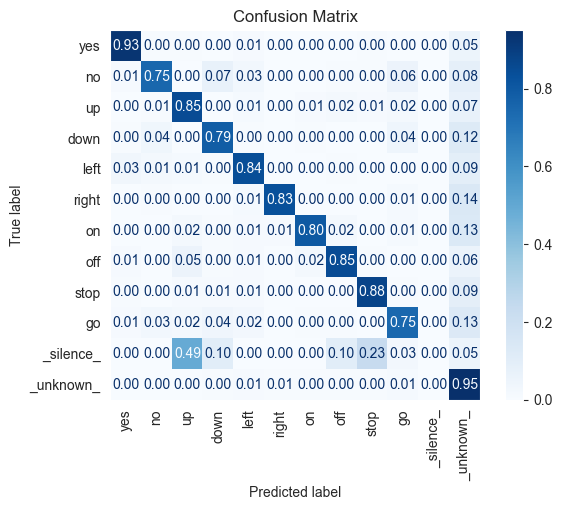

In [25]:
evaluate_and_plot_confusion_matrix(model, test_dataset)

In [43]:
def evaluate_and_display_wrong_predictions(model, test_dataset, n=5):
    model.to(device)
    model.eval()

    indices = list(range(len(test_dataset)))
    random.shuffle(indices)

    wrong_predictions = []

    for idx in indices:
        data, true_label = test_dataset[idx]

        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(data_tensor)
            probabilities = torch.softmax(output, dim=1)
            predicted_label = torch.argmax(output, dim=1).item()
            prediction_certainty = probabilities[0, predicted_label].item()

        if predicted_label != true_label:
            wrong_predictions.append((idx, true_label, predicted_label, prediction_certainty))

        if len(wrong_predictions) >= n:
            break

    for idx, true_label, predicted_label, prediction_certainty in wrong_predictions:
        print(f"Sample Index: {idx}")
        print(f"{true_label}, {predicted_label}, {prediction_certainty}")

        def get_key_by_value(dictionary, value):
            return next((k for k, v in dictionary.items() if v == value), '')
        true_label_name = get_key_by_value(test_dataset.label_mapping, true_label)
        predicted_label_name = get_key_by_value(test_dataset.label_mapping, predicted_label)
        print(f"True Label: {true_label_name}, Predicted Label: {predicted_label_name}")
        print(f"Prediction Certainty: {prediction_certainty:.2f}")

        waveform, _ = test_dataset.get_waveform(idx)
        display(Audio(waveform, rate=cfg.data.sample_rate))
        print("-" * 50)

In [44]:
evaluate_and_display_wrong_predictions(model, test_dataset)


Sample Index: 3064
1, 11, 0.5745934247970581
True Label: no, Predicted Label: _unknown_
Prediction Certainty: 0.57


--------------------------------------------------
Sample Index: 909
3, 11, 0.8932062387466431
True Label: down, Predicted Label: _unknown_
Prediction Certainty: 0.89


--------------------------------------------------
Sample Index: 6858
10, 2, 0.8767321109771729
True Label: _silence_, Predicted Label: up
Prediction Certainty: 0.88


--------------------------------------------------
Sample Index: 4173
5, 11, 0.7668313384056091
True Label: right, Predicted Label: _unknown_
Prediction Certainty: 0.77


--------------------------------------------------
Sample Index: 6857
10, 2, 0.5736662745475769
True Label: _silence_, Predicted Label: up
Prediction Certainty: 0.57


--------------------------------------------------
